In [1]:
#!pip3 install lfpykit

In [1]:
%matplotlib inline

# if you want a specific arbor load location after a custom cmake build
# from https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
import importlib
ARBOR_LOCATION = '/specialhome/lennart/Repos/arbor-sim/arbor/build/python/arbor/__init__.py'
spec = importlib.util.spec_from_file_location('arbor', ARBOR_LOCATION)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

import random
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt

import lfpykit
import arbor

import iopublic
iopublic.ARBOR_BUILD_CATALOGUE = '/specialhome/lennart/Repos/arbor-sim/arbor/build/arbor-build-catalogue'

# Shared code

In [2]:
# from https://github.com/LFPy/LFPykit/blob/master/examples/Example_Arbor_swc.ipynb

class ArborCellGeometry(lfpykit.CellGeometry):
    def __init__(self, p, cables):
        x, y, z, r = [], [], [], []
        CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
        for i, m in enumerate(cables):
            segs = p.segments([m])
            for j, seg in enumerate(segs):
                x.append([seg.prox.x, seg.dist.x])
                y.append([seg.prox.y, seg.dist.y])
                z.append([seg.prox.z, seg.dist.z])
                r.append([seg.prox.radius, seg.dist.radius])
                CV_ind = np.r_[CV_ind, i]
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        z = np.array(z, dtype=float)
        d = 2*np.array(r, dtype=float)
        super().__init__(x=x, y=y, z=z, d=d)
        self._CV_ind = CV_ind


class ArborLineSourcePotential(lfpykit.LineSourcePotential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix
    
    def get_transformation_matrix(self):
        M_tmp = self._get_transformation_matrix()
        n_CVs = np.unique(self.cell._CV_ind).size
        M = np.zeros((self.x.size, n_CVs))
        for i in range(n_CVs):
            inds = self.cell._CV_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] / self.cell.area[inds].sum())
        return M

# Example 1 - single spike

In [3]:
recipe = iopublic.build_recipe(
    '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be',
    spikes={5000: 0.01}
)
recipe

<arbor.recipe>

In [4]:
%%time

tfinal = 6000
dt = 0.025
gpu_id = 1

context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)

sim = arbor.simulation(recipe, domains, context)

#voltage_handles = [sim.sample((gid, 1), arbor.regular_schedule(1), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
#current_handles = [sim.sample((gid, 2), arbor.regular_schedule(1), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
current_handles = [sim.sample((gid, 2), arbor.regular_schedule(4750, 1, 6000), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]

sim.run(tfinal=tfinal, dt=dt)

#voltage_traces = [sim.samples(handle)[0] for handle in voltage_handles]
current_traces = [sim.samples(handle)[0] for handle in current_handles]

CPU times: user 3min 36s, sys: 3min 57s, total: 7min 34s
Wall time: 7min 31s


In [5]:
# each element of V_samples is [nsamples * (time, v(cv0), v(cv1), v(cv2))] etc
# indss = [np.array([m.dist!=m.prox for m in tr[1]]) for tr in voltage_traces]
# V_samples  = [tr[0][:, np.r_[True, inds]] for inds, tr in zip(indss, voltage_traces)]
# V_meta = [np.array(tr[1])[inds].tolist() for inds, tr in zip(indss, voltage_traces)]
I_samples  = [x[0] for x in current_traces]
I_meta = [x[1] for x in current_traces]
#for a,b  in zip(V_meta, I_meta):    assert a == b
#for a,b  in zip(V_samples, I_samples):    assert (a[:, 0]==b[:, 0]).all()
time = I_samples[0][0]
#V_m = [x[:,1:].T for x in V_samples]
I_m = [x[:,1:].T for x in I_samples]
print('There are', sum(map(len, I_m)), 'nonempty CVs')

There are 213447 nonempty CVs


In [6]:
N_SAMPLES = 64 # along 1 dimension. values > 10 = slow

# find an interesting plane:
# pick three points in the model
a = random.choice(recipe.neurons)
a = np.array([a.x, a.y, a.z])
b = random.choice(recipe.neurons)
b = np.array([b.x, b.y, b.z])
c = random.choice(recipe.neurons)
c = np.array([c.x, c.y, c.z])
# find 2d plane through the points
u = b - a
v = c - a
point = np.array([a, b, c]).mean(0)
normal = np.cross(u, v)
normal = normal / np.linalg.norm(normal)
# find a sensible scale given the points
scale = np.array([np.linalg.norm(b - a), np.linalg.norm(c - a), np.linalg.norm(b - c)]).mean()
# create two orthogonal vectors inside the plane
e0 = b - a
e1 = np.cross(e0, b)
e0 = e0 / np.linalg.norm(e0)
e1 = e1 / np.linalg.norm(e1)

# 1 coord
s = np.linspace(-scale*0.8, scale*0.8, N_SAMPLES)

# meshgrid that:
Xplane, Yplane = np.meshgrid(s, s)
X, Y, Z = point[:, None] + \
    Xplane.flatten()[None, :]*e0[:, None] + \
    Yplane.flatten()[None, :]*e1[:, None]

In [7]:
%%time

# original:                                               6 mins 56 seconds
# numba.jit(nopython=True, nogil=True)                    2 mins 6
# numba.jit(nopython=True, nogil=True, fastmath=True)     2 mins 3 seconds
# numba.jit(..., parallel=True) + prange() in M = ...     1 mins 56 seconds

lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    geometries.append(cell_geometry)
    lsps.append(lsp)
    Ms.append(M)
    print(gid, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [16]:
%%time
# Extracellular potential in x,y-plane
# V_ext contains potential for each neurons
#V_ext = np.array([Ms[gid] @ I_m[gid] for gid in range(recipe.num_cells()) if len(Ms) > gid])
# V_e sums up the individual neurons contributions
#V_e = np.nan_to_num(V_ext).sum(0).reshape(*Xplane.shape, -1)
V_ext = 0
for gid in range(recipe.num_cells()):
    # In a loop to reduce memory usage
    # We'll run out of all 128GB RAM if we do np.array([M @ I for M, I in zip(Ms, I_m)])
    V_ext = V_ext + np.nan_to_num(Ms[gid] @ I_m[gid])
V_ext = V_ext.reshape((N_SAMPLES, N_SAMPLES, -1))

CPU times: user 9min 23s, sys: 1h 9min 46s, total: 1h 19min 10s
Wall time: 1min 17s


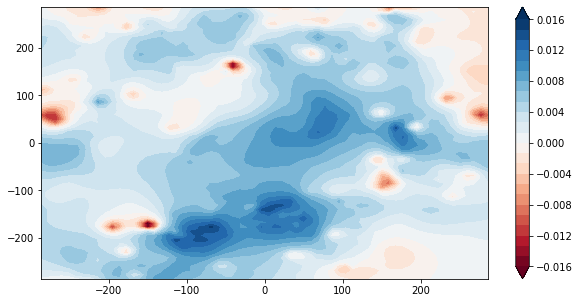

In [17]:
plt.figure(figsize=(10, 5))
lim = float(f'{abs(V_ext).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(Xplane, Yplane, V_ext[..., -1], cmap='RdBu', levels=levels, extend='both')
plt.colorbar();

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

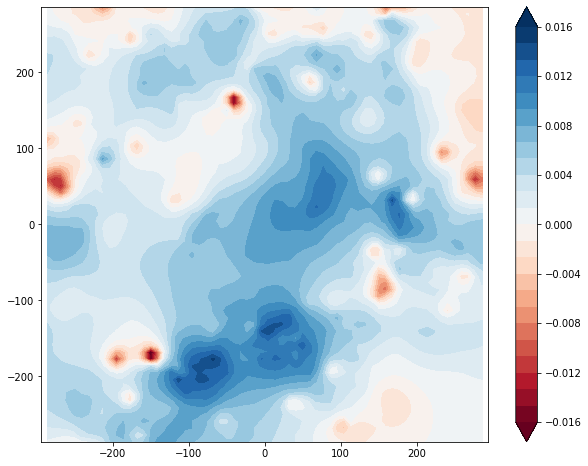

In [23]:
%%time

import subprocess
import os
import matplotlib.animation as animation

lim = float(f'{abs(V_ext).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
fig = plt.figure(figsize=(10, 8))

!rm -fr img/moviempl
!mkdir img/moviempl

frames = []
for i in range(0, V_ext.shape[2], 1):
    fig.clf()
    plt.contourf(Xplane, Yplane, V_ext[..., i], cmap='RdBu', levels=levels, extend='both')
    plt.axis('equal')
    plt.colorbar();
    plt.savefig("img/moviempl/%05d.png" % i)
    print(i, end=' ', flush=True)

# no ffmpeg here, but we can do this from outside the container
# ffmpeg -framerate 100 -i img/moviempl/%05d.png -r 30 -pix_fmt yuv420p lfp.mp4

In [ ]:
!ls

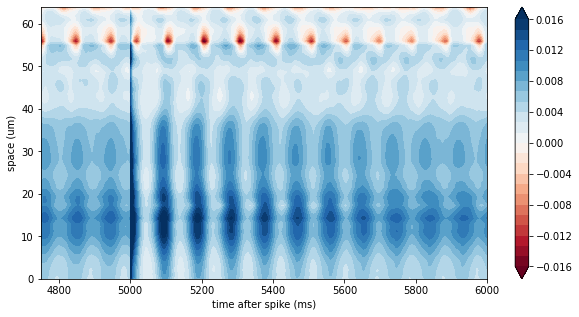

In [27]:
plt.figure(figsize=(10, 5))
lim = float(f'{abs(V_ext).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(V_ext[:, 30, :], cmap='RdBu', levels=levels, extend='both',
             extent=(4750, 6000, 0, V_ext.shape[1]))
plt.colorbar()
plt.xlabel('time after spike (ms)')
plt.ylabel('space (um)')
plt.savefig('lfp_space_time_big.pdf')
plt.savefig('lfp_space_time_big.png')

In [28]:
def go(N_SAMPLES = 10, f=0.8, sigma=None):
    # find an interesting plane:
    # pick three points in the model
    a = random.choice(recipe.neurons)
    a = np.array([a.x, a.y, a.z])
    b = random.choice(recipe.neurons)
    b = np.array([b.x, b.y, b.z])
    c = random.choice(recipe.neurons)
    c = np.array([c.x, c.y, c.z])
    # find 2d plane through the points
    u = b - a
    v = c - a
    point = np.array([a, b, c]).mean(0)
    normal = np.cross(u, v)
    normal = normal / np.linalg.norm(normal)
    # find a sensible scale given the points
    scale = np.array([np.linalg.norm(b - a), np.linalg.norm(c - a), np.linalg.norm(b - c)]).mean()
    # create two orthogonal vectors inside the plane
    e0 = b - a
    e1 = np.cross(e0, b)
    e0 = e0 / np.linalg.norm(e0)
    e1 = e1 / np.linalg.norm(e1)

    # 1 coord
    s = np.linspace(-scale*f, scale*f, N_SAMPLES)
    print('reso', s[1] - s[0], 'um')

    # meshgrid that:
    Xplane, Yplane = np.meshgrid(s, s)
    X, Y, Z = point[:, None] + \
        Xplane.flatten()[None, :]*e0[:, None] + \
        Yplane.flatten()[None, :]*e1[:, None]

    lsps = []
    Ms = []
    geometries = []
    for gid in range(recipe.num_cells()):
        segtree = recipe.cell_morphology(gid)
        p = arbor.place_pwlin(arbor.morphology(segtree))
        cell_geometry = ArborCellGeometry(p, I_meta[gid])
        lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z, sigma=sigma)
        M = lsp.get_transformation_matrix()
        geometries.append(cell_geometry)
        lsps.append(lsp)
        Ms.append(M)
        print(gid, end=' ')

    # Extracellular potential in x,y-plane
    # V_ext contains potential for each neurons
    V_ext = np.array([Ms[gid] @ I_m[gid] for gid in range(recipe.num_cells()) if len(Ms) > gid])
    # V_e sums up the individual neurons contributions
    V_e = np.nan_to_num(V_ext).sum(0).reshape(*Xplane.shape, -1)

    return Xplane, Yplane, V_e, s

In [12]:
xx, yy, ee, s = go(8, 0.05, 0.3)

reso 10.289628723649106 um
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270

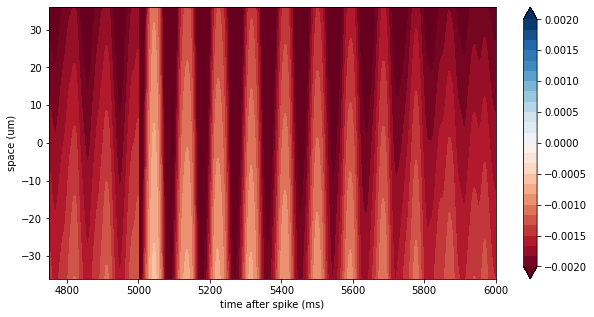

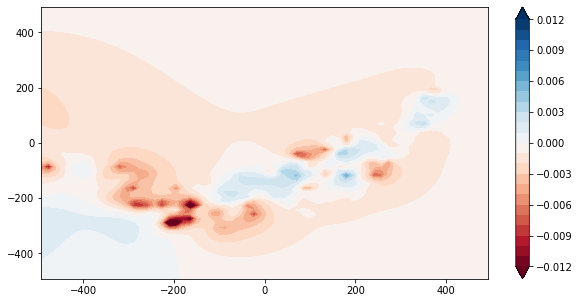

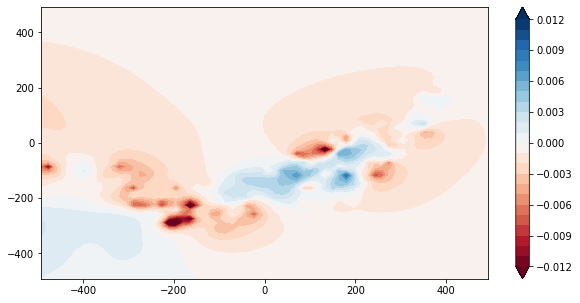

In [16]:
plt.figure(figsize=(10, 5))
lim = float(f'{abs(ee).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(ee[:, 3, :], cmap='RdBu', levels=levels, extend='both',
             extent=(4750, 6000, s.min(), s.max()))
plt.colorbar()
plt.xlabel('time after spike (ms)')
plt.ylabel('space (um)')
plt.savefig('lfp_space_time.pdf')
plt.savefig('lfp_space_time.png')

plt.figure(figsize=(10, 5))
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(Xplane, Yplane, V_e[..., 10], cmap='RdBu', levels=levels, extend='both')
plt.colorbar()

plt.figure(figsize=(10, 5))
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(Xplane, Yplane, V_e[..., -1], cmap='RdBu', levels=levels, extend='both')
plt.colorbar()

# Example 2: Spike train

In [3]:
%%time
selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
neurons = iopublic.get_network_for_tuning(selected).neurons

tfinal = 6000
dt = 0.025
gpu_id = 1

def spiketrain(f_hz):
    x = 0
    l = []
    while True:
        interval = np.random.poisson(lam=1000/f_hz)
        x = x + interval
        if x > tfinal:
            return l
        l.append(x)

spikes = {}
for at in spiketrain(f_hz=100):
    tgt = random.choice(neurons)
    tgt = np.array([tgt.x, tgt.y, tgt.z])
    spikes[at] = [*tgt, 50, -0.01]

recipe = iopublic.build_recipe(
    selected,
    spikes=spikes
)

context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)
current_handles = [sim.sample((gid, 2), arbor.regular_schedule(4750, 1, 6000), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
sim.run(tfinal=tfinal, dt=dt)
current_traces = [sim.samples(handle)[0] for handle in current_handles]
I_samples  = [x[0] for x in current_traces]
I_meta = [x[1] for x in current_traces]
time = I_samples[0][0]
I_m = [x[:,1:].T for x in I_samples]
print('There are', sum(map(len, I_m)), 'nonempty CVs')

There are 213435 nonempty CVs
CPU times: user 3min 46s, sys: 3min 59s, total: 7min 45s
Wall time: 7min 42s


In [5]:
%%time
N_SAMPLES = 64 # along 1 dimension. values > 10 = slow
a = random.choice(recipe.neurons)
a = np.array([a.x, a.y, a.z])
b = random.choice(recipe.neurons)
b = np.array([b.x, b.y, b.z])
c = random.choice(recipe.neurons)
c = np.array([c.x, c.y, c.z])
u = b - a
v = c - a
point = np.array([a, b, c]).mean(0)
normal = np.cross(u, v)
normal = normal / np.linalg.norm(normal)
scale = np.array([np.linalg.norm(b - a), np.linalg.norm(c - a), np.linalg.norm(b - c)]).mean()
e0 = b - a
e1 = np.cross(e0, b)
e0 = e0 / np.linalg.norm(e0)
e1 = e1 / np.linalg.norm(e1)
s = np.linspace(-scale*0.8, scale*0.8, N_SAMPLES)
Xplane, Yplane = np.meshgrid(s, s)
X, Y, Z = point[:, None] + Xplane.flatten()[None, :]*e0[:, None] + Yplane.flatten()[None, :]*e1[:, None]
lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    geometries.append(cell_geometry)
    lsps.append(lsp)
    Ms.append(M)
    print(gid, end=' ')
V_ext = 0
for gid in range(recipe.num_cells()):
    V_ext = V_ext + np.nan_to_num(Ms[gid] @ I_m[gid])
V_ext = V_ext.reshape((N_SAMPLES, N_SAMPLES, -1))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

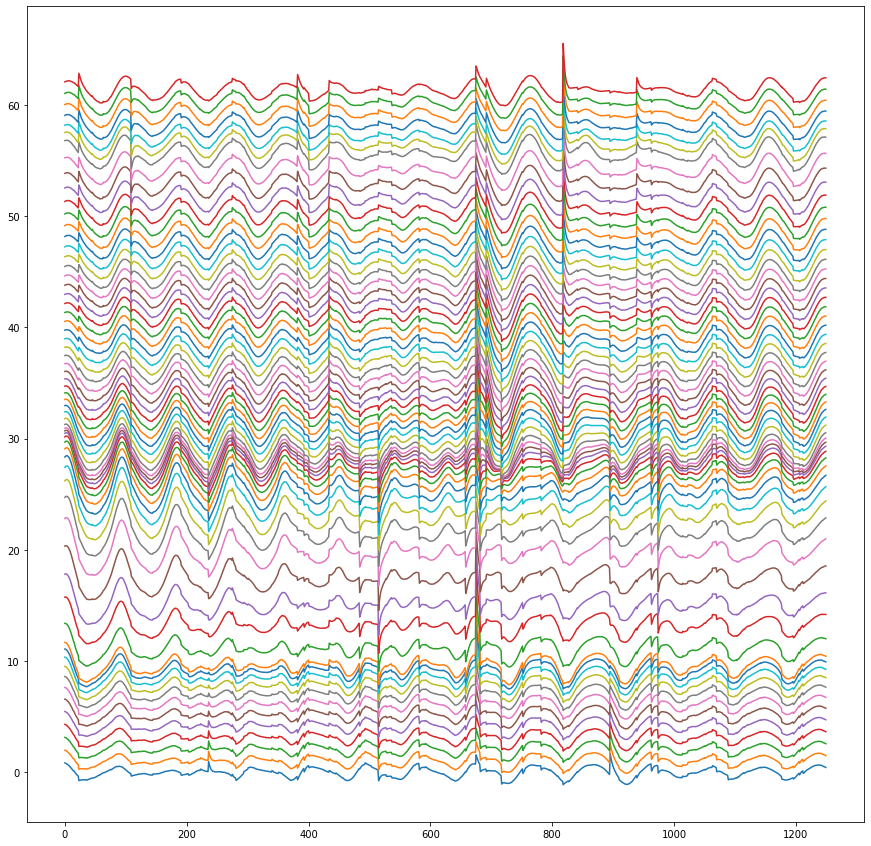

In [25]:
plt.figure(figsize=(15, 15))
for i in range(N_SAMPLES):
    plt.plot(i + 1e3*V_ext[i,32,:])

# Example 3: 2 localized spikes

In [3]:
selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
neurons = iopublic.get_network_for_tuning(selected).neurons

In [4]:
# stimulate two neurons, sample along a line connecting them

a = random.choice(neurons)
b = random.choice(neurons)

a = np.array([a.x, a.y, a.z])
b = np.array([b.x, b.y, b.z])

point = np.array([a, b]).mean(0)

normal = b - a
normal = normal / np.linalg.norm(normal)
scale = np.linalg.norm(b - a)

In [5]:
radius = 300

recipe = iopublic.build_recipe(
    selected,
    spikes={
        5000:    [*a, radius, 0.02],
        5000.01: [*b, radius, -0.02]}
)
recipe

<arbor.recipe>

In [6]:
%%time

tfinal = 6000
dt = 0.025
gpu_id = 1
context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)
tmem_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(4750, 1, 6000), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
stim_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(4750, 1, 6000), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
handles = [sim.sample((gid, 0), arbor.regular_schedule(1)) for gid in range(recipe.num_cells())]
sim.run(tfinal=tfinal, dt=dt)

CPU times: user 4min 54s, sys: 4min 38s, total: 9min 32s
Wall time: 9min 30s


6000.0

In [11]:
tmem_current_traces = [sim.samples(handle)[0] for handle in tmem_current_handles]
stim_current_traces = [sim.samples(handle)[0] for handle in stim_current_handles]
traces = [sim.samples(handle)[0][0].T for handle in handles]
vsall = np.array([vs for t, vs in traces])
I_meta = [x[1] for x in tmem_current_traces]
I_m  = [tmem[0][:,1:].T + stim[0][:,1:].T for tmem, stim in zip(tmem_current_traces, stim_current_traces)]
print('There are', sum(map(len, I_m)), 'nonempty CVs')

There are 213417 nonempty CVs


In [3]:
# 44 sec

def go(gid):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    return gid, cell_geometry, lsp, M




N_SAMPLES = 256 # 1d, not 2d, so can we a bit higher than in the 2d version
s = np.linspace(-scale*0.8, scale*0.8, N_SAMPLES)
X, Y, Z = point[:, None] + s[None, :]*normal[:, None]



with ThreadPoolExecutor(max_workers=128) as executor:
    prev = -1
    for gid, cell_geometry, lsp, M in []:#executor.map(go, range(recipe.num_cells())):
        assert prev + 1 == gid
        prev = gid
        geometries.append(cell_geometry)
        lsps.append(lsp)
        Ms.append(M)
        print(gid)
        
# from https://github.com/LFPy/LFPykit/blob/master/examples/Example_Arbor_swc.ipynb
class ArborCellGeometry(lfpykit.CellGeometry):

lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid]) # SLOW
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    #M = lsp.get_transformation_matrix() # SLOW
    geometries.append(cell_geometry)
    lsps.append(lsp)
    #Ms.append(M)
    print(gid, end=' ')

NameError: name 'scale' is not defined

In [4]:
import pickle
#with open('lsps.pc', 'wb') as f: pickle.dump(lsps, f)
with open('lsps.pc', 'rb') as f:
    lsps = pickle.load(f)

In [20]:
%%time


from lfpykit import lfpcalc

def _get_transformation_matrix(self):
    if self.cell is None:
        raise AttributeError(
            '{}.cell is None'.format(self.__class__.__name__))
    M = np.empty((self.x.size, self.cell.totnsegs))
    if self.cell.d.ndim == 2:
        r_limit = self.cell.d.mean(axis=-1) / 2
    else:
        r_limit = self.cell.d / 2
    for j in range(self.x.size):
        M[j, :] = lfpcalc.calc_lfp_linesource(self.cell,
                                              x=self.x[j],
                                              y=self.y[j],
                                              z=self.z[j],
                                              sigma=self.sigma,
                                              r_limit=r_limit)
    return M

def get_transformation_matrix(self):
    M_tmp = _get_transformation_matrix(self)
    n_CVs = np.unique(self.cell._CV_ind).size
    M = np.zeros((self.x.size, n_CVs))
    for i in range(n_CVs):
        inds = self.cell._CV_ind == i
        M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] / self.cell.area[inds].sum())
    return M


for lsp in lsps:
    M = get_transformation_matrix(lsp)
    

CPU times: user 7.07 s, sys: 0 ns, total: 7.07 s
Wall time: 7.07 s


In [19]:
%%time

Ms = []
with ThreadPoolExecutor(max_workers=4) as executor:
    for M in executor.map(get_transformation_matrix, lsps):
        Ms.append(M)

CPU times: user 13 s, sys: 7.46 s, total: 20.5 s
Wall time: 10 s


In [16]:
%%time
# Extracellular potential in x,y-plane
# V_ext contains potential for each neurons
V_ext = np.array([Ms[gid] @ I_m[gid] for gid in range(recipe.num_cells()) if len(Ms) > gid])
# V_e sums up the individual neurons contributions
V_e = np.nan_to_num(V_ext).sum(0).reshape(*s.shape, -1)

NameError: name 'recipe' is not defined

In [14]:
Ms[0].shape, I_m[0].shape

((256, 31), (31, 1250))

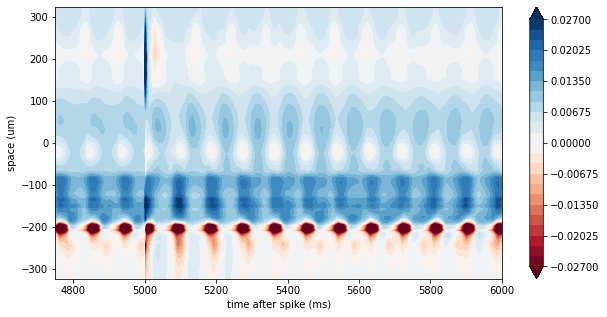

In [26]:
plt.figure(figsize=(10, 5))
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(V_e, cmap='RdBu', levels=levels, extend='both',
             extent=(4750, 6000, s.min(), s.max()))
plt.colorbar()
plt.xlabel('time after spike (ms)')
plt.ylabel('space (um)')
plt.savefig('img/lfp_space_time_line.pdf')
plt.savefig('img/lfp_space_time_line.png')

Text(0, 0.5, 'space (um)')

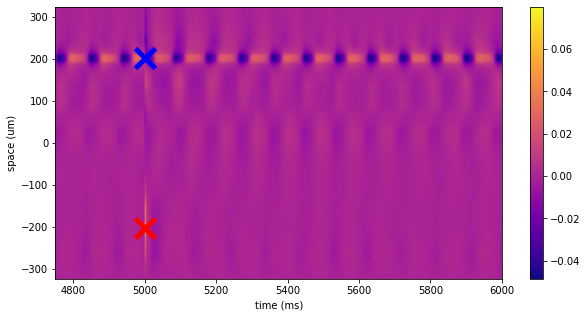

In [25]:
plt.figure(figsize=(10, 5))
plt.imshow(V_e - V_e.mean(1)[:,None], extent=(4750, 6000, s.min(), s.max()), cmap='plasma', aspect='auto')#, vmin=-lim, vmax=lim, )

plt.plot(5000, (point - a) @ normal, 'x', color='blue', markersize=20, markeredgewidth=5)
plt.plot(5000, (point - b) @ normal, 'x', color='red', markersize=20, markeredgewidth=5)

#plt.xlim([4995, 5010])
plt.colorbar()

plt.xlabel('time (ms)')
plt.ylabel('space (um)')

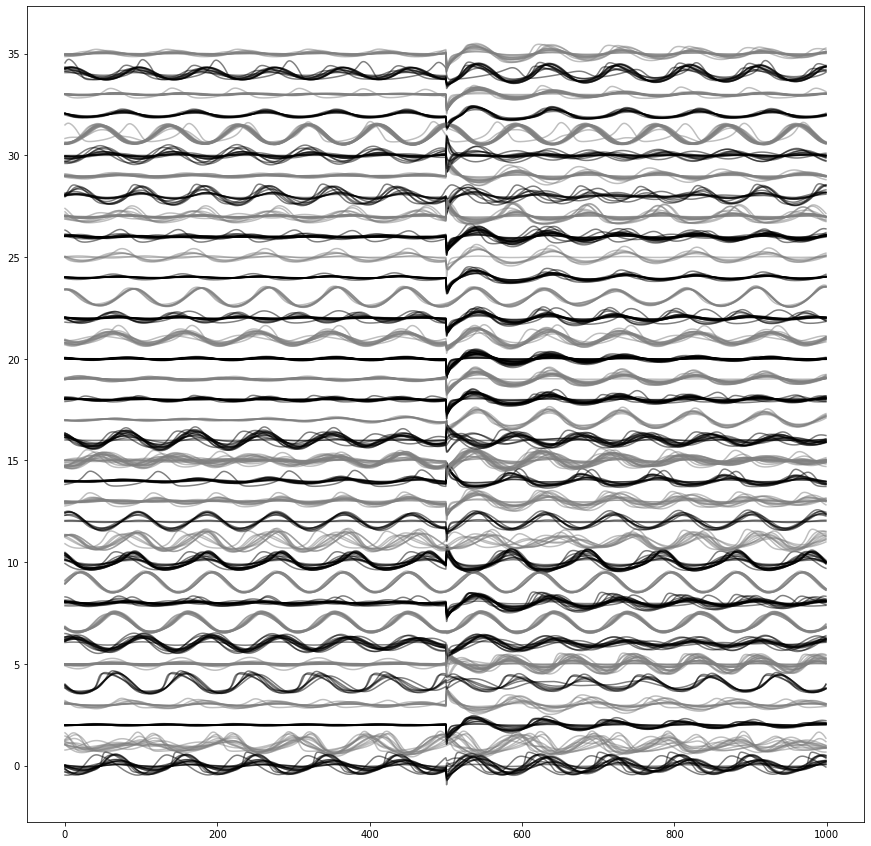

In [17]:
plt.figure(figsize=(15, 15))

for n, vs in zip(neurons, vsall):
    v = vs[4500:5500]
    v = (v - v.mean()) / v.ptp()
    if n.cluster > 35: continue
    plt.plot(v + n.cluster, color=['black', 'gray'][n.cluster%2], alpha=0.5)

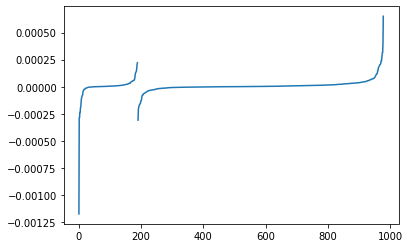

In [18]:
plt.plot(sorted(V_ext[:, 128, 250]))

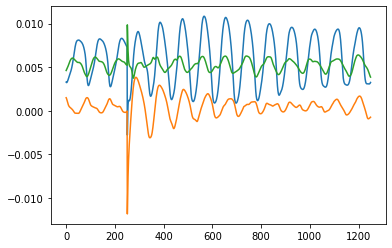

In [19]:
plt.plot(V_e[128, :])
plt.plot(V_e[0, :])
plt.plot(V_e[255, :])

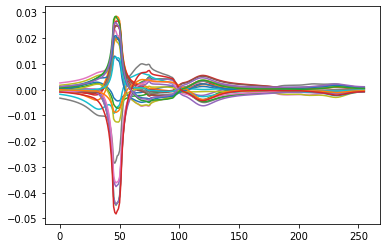

In [20]:
for i in range(0, 1250, 50):
    plt.plot(V_e[:, i] - V_e.mean(1))


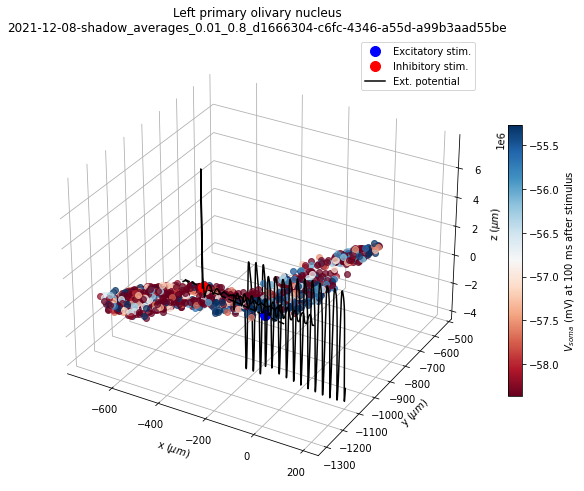

In [23]:
import matplotlib as mpl

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

cmap = plt.get_cmap('RdBu')
q = np.nan_to_num(vsall[:,4000:])
volts = q[:,1100]
#volts = np.array([n.cluster for n in neurons])
vmin = q.mean() - 0.5 * q.std()
vmax = q.mean() + 0.5 * q.std()
volts = (volts - vmin) / (vmax - vmin)
for gid, n, in enumerate(neurons):
    color = cmap(volts[gid])
    zz = np.interp(n.x, X, Z)
    zorder = 1 if n.z > zz else -1
    plt.plot(n.x, n.y, n.z, 'o', color=color, alpha=0.7, zorder=zorder)

plt.plot(X, Y, Z, '--', color='black')
plt.plot(*a, 'o', color='blue', markersize=10, label='Excitatory stim.')
plt.plot(*b, 'o', color='red', markersize=10, label='Inhibitory stim.')

#for i in range(0, 1250, 10):  plt.plot(X + -i, Y, Z + (V_e[:, i] - V_e.mean(1))*1e8, color='blue', alpha=0.5, zorder=-1)
fst = True
for i in [48, 127, 208,]:
    v = (V_e[i, :] - V_e[i, 0])*1e8
    vv = np.linspace(-250, 1000, len(v)) / 3
    x, y, z = X[i] + vv, Y[i] + 0*v, Z[i] + v
    if fst:
        lbl = 'Ext. potential'
    else:
        lbl = None
    plt.plot(x[:250], y[:250], z[:250], color='black', zorder=-2, label=lbl)
    plt.plot(x[250:], y[250:], z[250:], color='black', zorder=2)
    fst = False

plt.xlabel('x ($\\mu m$)')
plt.ylabel('y ($\\mu m$)')
ax.set_zlabel('z ($\\mu m$)')



ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(True)

plt.legend()
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
             ax=ax,label='$V_{soma}$ (mV) at 100 ms after stimulus', shrink=0.5)

plt.title(f'Left primary olivary nucleus\n{selected}')

plt.savefig('img/lfp_3d.pdf')
plt.savefig('img/lfp_3d.png')

In [ ]:
np.where(np.isnan(vsall[:,5000]))

In [ ]:
s = np.linspace(-1, 1)
plt.plot(cmap(s))

In [ ]:
np.interp